In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from allison.nn import Relu,Linear
from allison.nn import SGDMomentum
from allison.nn import Tensor,no_grad
from allison.nn import NeuralNetwork
from allison.nn import CrossEntropyLoss
from allison.metrics import confusion_matrix,classification_report
from allison.datasets import train_test_split
import pandas as pd
import joblib
import seaborn as sns
from allison.metrics import classification_report,confusion_matrix

# Datos

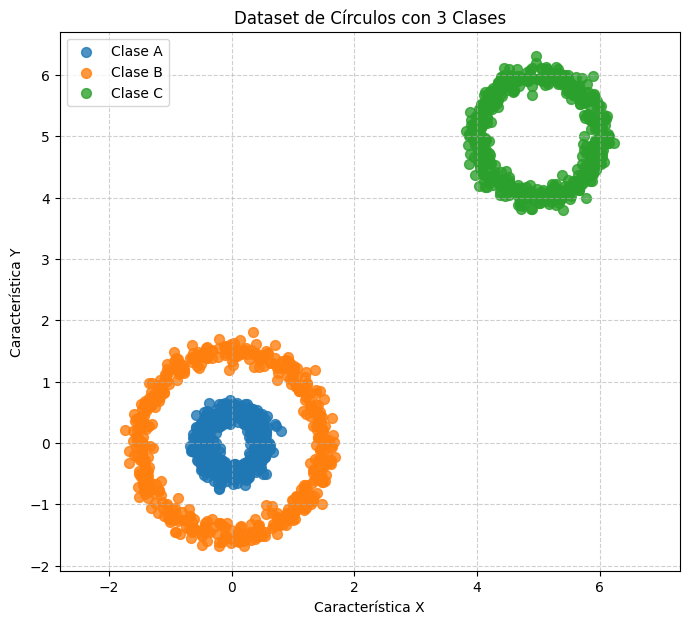

In [2]:
r1 = 0.5  
r2 = 1.5  
r3 = 1  

num_points = 500
thetas = np.linspace(0, 2 * np.pi, num_points) 


x1 = r1 * np.cos(thetas) + 0.1 * np.random.randn(num_points)
y1 = r1 * np.sin(thetas) + 0.1 * np.random.randn(num_points)


x2 = r2 * np.cos(thetas) + 0.1 * np.random.randn(num_points)
y2 = r2 * np.sin(thetas) + 0.1 * np.random.randn(num_points)


x3 = 5 + r3 * np.cos(thetas) + 0.1 * np.random.randn(num_points)
y3 = 5 + r3 * np.sin(thetas) + 0.1 * np.random.randn(num_points)


plt.figure(figsize=(8, 7)) 


plt.scatter(x1, y1, s=50, label="Clase A", alpha=0.8) # Puntos de la Clase A
plt.scatter(x2, y2, s=50, label="Clase B", alpha=0.8) # Puntos de la Clase B
plt.scatter(x3, y3, s=50, label="Clase C", alpha=0.8) # Puntos de la Clase C

plt.xlabel("Característica X") 
plt.ylabel("Característica Y")
plt.title("Dataset de Círculos con 3 Clases")
plt.legend() 
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal')
plt.show() 


In [3]:
df = pd.DataFrame(
    {"x": x1.tolist()+x2.tolist()+x3.tolist(),
    "y": y1.tolist()+y2.tolist()+y3.tolist(),
    "labels":['A' for _ in range(num_points)]+['B' for _ in range(num_points)]+['C' for _ in range(num_points)]
    })

labels = df["labels"].unique()
labels2id = {label: i for i, label in enumerate(labels)}
id2labels = {v: k for k, v in labels2id.items()}

df["labels"] = df["labels"].map(labels2id)
df.head()

,x,y,labels
0,0.428217,0.021796,0
1,0.489678,-0.124373,0
2,0.290522,-0.011994,0
3,0.466911,0.103790,0
4,0.563878,0.174139,0


In [4]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

X_train = Tensor(df_train[["x","y"]].values)
Y_train = Tensor(df_train[["labels"]].values)

X_test = Tensor(df_test[["x","y"]].values)
Y_test = Tensor(df_test[["labels"]].values)

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")


X_train shape: (1200, 2)
Y_train shape: (1200, 1)
X_test shape: (300, 2)
Y_test shape: (300, 1)


In [5]:
class Network(NeuralNetwork):
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(2, 4)
        self.relu = Relu()
        self.fc2 = Linear(4, 4)
        self.fc3 = Linear(4, 3)

    def forward(self, x: Tensor) -> Tensor:
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


net = Network()

net.load_weights(joblib.load('model_weights.joblib'))


In [6]:
with no_grad():
    y_pred = net(X_test).data.argmax(axis=1,keepdims=True).flatten()

y_true = Y_test.data.flatten()
print(classification_report(y_true, y_pred))

            precision   recall f1-score  support
0                0.78     0.99     0.87       90
1                0.99     0.74     0.84       95
2                1.00     1.00     1.00      115

accuracy                           0.91      300
macro avg        0.92     0.91     0.91      300
weighted avg     0.93     0.91     0.91      300


In [7]:
optimizer = SGDMomentum(net.parameters(), learning_rate=1e-3, momentum=0.9)
criterion = CrossEntropyLoss()

In [8]:
# Bucle de entrenamiento mejorado
for epoch in range(10000 + 1):
    out = net(X_train)
    loss = criterion(Y_train, out)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        acc_train = np.mean(out.data.argmax(axis=1, keepdims=True) == Y_train.data)
        with no_grad():
            out = net(X_test)
            acc_test = np.mean(out.data.argmax(axis=1, keepdims=True) == Y_test.data)

        # Usamos una f-string para formatear y alinear la salida
        print(f"Epoch {epoch:5d} | Loss: {loss.data:.4f} | Acc Train: {acc_train*100:.2f}% | Acc Test: {acc_test*100:.2f}%")

        if acc_test >= 0.98:  # Mejoramos el criterio de parada
            print(f"Entrenamiento completado en {epoch} epochs!")
            break

Epoch     0 | Loss: 0.3637 | Acc Train: 89.17% | Acc Test: 91.33%
Epoch   100 | Loss: 0.3552 | Acc Train: 91.17% | Acc Test: 93.33%
Epoch   200 | Loss: 0.3457 | Acc Train: 92.67% | Acc Test: 94.67%
Epoch   300 | Loss: 0.3359 | Acc Train: 93.42% | Acc Test: 94.67%
Epoch   400 | Loss: 0.3257 | Acc Train: 94.50% | Acc Test: 96.00%
Epoch   500 | Loss: 0.3153 | Acc Train: 95.25% | Acc Test: 96.33%
Epoch   600 | Loss: 0.3046 | Acc Train: 96.42% | Acc Test: 96.33%
Epoch   700 | Loss: 0.2934 | Acc Train: 96.92% | Acc Test: 96.67%
Epoch   800 | Loss: 0.2819 | Acc Train: 97.25% | Acc Test: 97.00%
Epoch   900 | Loss: 0.2705 | Acc Train: 97.25% | Acc Test: 97.33%
Epoch  1000 | Loss: 0.2592 | Acc Train: 97.25% | Acc Test: 97.33%
Epoch  1100 | Loss: 0.2479 | Acc Train: 97.33% | Acc Test: 97.33%
Epoch  1200 | Loss: 0.2369 | Acc Train: 97.42% | Acc Test: 97.33%
Epoch  1300 | Loss: 0.2260 | Acc Train: 97.58% | Acc Test: 97.67%
Epoch  1400 | Loss: 0.2152 | Acc Train: 97.92% | Acc Test: 97.67%
Epoch  150

In [9]:
with no_grad():
    y_pred = net(X_test).data.argmax(axis=1,keepdims=True).flatten()

y_true = Y_test.data.flatten()
print(classification_report(y_true, y_pred))

            precision   recall f1-score  support
0                0.95     0.99     0.97       90
1                0.99     0.95     0.97       95
2                1.00     1.00     1.00      115

accuracy                           0.98      300
macro avg        0.98     0.98     0.98      300
weighted avg     0.98     0.98     0.98      300
